In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import PIL.Image
from torch import nn, optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [ ]:
# Use GPU if available
device = torch.device("cuda:0")

# Download data set using Kaggle API

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
# Download data set from Kaggle
! kaggle competitions download digit-recognizer -f train.csv
! kaggle competitions download digit-recognizer -f test.csv

 76% 7.00M/9.16M [00:00<00:00, 65.5MB/s]
100% 9.16M/9.16M [00:00<00:00, 76.5MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 109MB/s]


In [ ]:
# unzip downloaded data set
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


#Data Preprocessing

##Import data

In [ ]:
# Import training and test set
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Split data into images and labels
# "In" for images
# "Out" for labels
out_trainall = train['label'].values
in_trainall = (train.iloc[:,1:].values).astype('float32')

in_test = (test.iloc[:,:].values).astype('float32')

# check data
in_trainall.shape, out_trainall.shape, in_test.shape

((42000, 784), (42000,), (28000, 784))

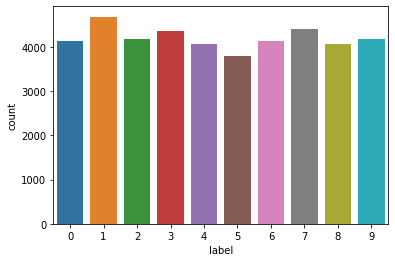

In [ ]:
# Bar plot of number of each number
sns.countplot(x='label', data=train);

##Split data for training and validation

In [ ]:
# split train on train and validation
in_train, in_val, out_train, out_val = train_test_split(in_trainall, out_trainall, test_size=0.2)

print(in_train.shape)
print(out_train.shape)
print(in_val.shape)
print(out_val.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


In [ ]:
# Data normalization
in_train = in_train.reshape(in_train.shape[0], 28, 28)
in_test = in_test.reshape(in_test.shape[0], 28, 28)
in_train.shape, in_test.shape

((33600, 28, 28), (28000, 28, 28))

In [ ]:
in_train_tensor = transforms.Compose([transforms.ToTensor()])

In [ ]:
# Train
in_train_tensor = torch.tensor(in_train)/255.0
out_train_tensor = torch.tensor(out_train)
train_tensor = TensorDataset(in_train_tensor, out_train_tensor)

#Validation
in_val_tensor = torch.tensor(in_val)/255.0
out_val_tensor = torch.tensor(out_val)
val_tensor = TensorDataset(in_val_tensor, out_val_tensor)

# test
# in_test_tensor = torch.tensor(in_test)/255.0

In [ ]:
# set the batch size to 64
# load the data
batch = 64
load_train = DataLoader(train_tensor, batch_size=batch, shuffle=True)
load_val = DataLoader(val_tensor, batch_size=batch, shuffle=True)

In [ ]:
class_names = {index:cn for index, cn in enumerate(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])}

##Plot Training Data Set

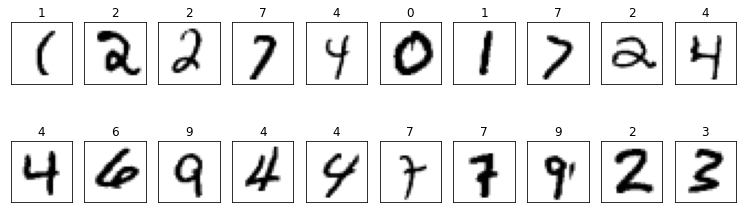

In [ ]:
# plot a grid of images with titles of correct names and labels of predicted names
num =2
def plot(images, labels, predictions=None):
    # create a grid with 10 columns
    n_cols = 10
    n_rows = num
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 3, n_rows + 2))
    if predictions is None:
        predictions = [None] * len(labels)
    for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
        ax = axes.flat[index]
        ax.imshow(x, cmap=plt.cm.binary)
        ax.set_title(class_names[y_true])
        if y_pred is not None:
            ax.set_xlabel(class_names[y_pred])
        ax.set_xticks([])
        ax.set_yticks([])

# plot first 10 * num images
plot(in_train[:10*num], out_train[:10*num]) 

#Methods

##Fully Connected Neural Network (FCNN)

###Build the neural network

In [ ]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) # Input size = 28*28, apply linear transformation to 256
        self.fc2 = nn.Linear(256, 128) # apply linear transformation to 128
        self.fc3 = nn.Linear(128, 64) # apply linear transformation to 64
        self.fc4 = nn.Linear(64, 10) # apply linear transformation to output, output size = 10

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened into 784 
        x = x.view(x.shape[0], -1)
        
        # apply the rectified linear unit function element-wise
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1) 
        
        return x

In [ ]:
# define the model
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###Training data set

In [ ]:
# Train the FNN model
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
#error = nn.CrossEntropyLoss()
# this criterion computes the cross entropy loss between input and target
error = nn.CrossEntropyLoss()
error = error.cuda()

#create a list to record every loss
fnn_losses =[]
epochs = 30

for epoch in range(epochs):
  running_loss = 0

  # go through all the images in training set
  for images, labels in load_train:
    optimizer.zero_grad() # training pass

    outputs = model(images)
    loss = error(outputs, labels)
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:

      outputs = model(images)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    fnn_losses.append(running_loss/len(load_train)) # Record loss for plot
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/30 - loss: 0.007641561581265359 - accuracy: 0.928898811340332
Epoch 2/30 - loss: 0.002974285184838144 - accuracy: 0.9586309790611267
Epoch 3/30 - loss: 0.0021410505365513795 - accuracy: 0.9661309719085693
Epoch 4/30 - loss: 0.0017318593706503245 - accuracy: 0.9729166626930237
Epoch 5/30 - loss: 0.001430758944743069 - accuracy: 0.977351188659668
Epoch 6/30 - loss: 0.0012237964548486551 - accuracy: 0.9818452596664429
Epoch 7/30 - loss: 0.001013675010437423 - accuracy: 0.9835714101791382
Epoch 8/30 - loss: 0.001009656917418137 - accuracy: 0.9816368818283081
Epoch 9/30 - loss: 0.000879185060905348 - accuracy: 0.9814881086349487
Epoch 10/30 - loss: 0.0007750201597792468 - accuracy: 0.9873809814453125
Epoch 11/30 - loss: 0.0006822774145396017 - accuracy: 0.9858928322792053
Epoch 12/30 - loss: 0.0007226433928268046 - accuracy: 0.9884523749351501
Epoch 13/30 - loss: 0.0005972925389263158 - accuracy: 0.9872321486473083
Epoch 14/30 - loss: 0.0005626160270973438 - accuracy: 0.992261886596

###Validation data set

In [ ]:
# Check the accuracy by using validation data set
count = 0
correct = 0
for images, labels in load_val:
  val = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(val)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
# Print outcome
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 8400 images - accuracy: 0.9648809432983398


##Convolutional neural network (CNN)

###Preprocess data for CNN

In [ ]:
# define a dataset class to transform data set
class trans(torch.utils.data.Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # We reshape the image data into the form expected by torchvision.
        X = np.reshape(self.X[idx], (28, 28, 1))
        if self.transforms is not None:
            X = self.transforms(X)
        if self.y is not None:
            return X, self.y[idx]
        else:
            return X

In [ ]:
# Normalize our pixel data such that the mean and standard deviation of each is 0.5.
transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# No random transformations for the test set.
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [ ]:
# Use the funtion to transform each data set.
train_data = trans(X=in_train, y=out_train, transforms=transform_train)
val_data = trans(X=in_val, y=out_val, transforms=transform_train)
test_data = trans(X=in_test, transforms=transform_test)

In [ ]:
# Set the batch size to 64.
batch = 64

# Load the training data and validation data
load_train = DataLoader(train_data, batch_size=batch, shuffle=True)
load_val = DataLoader(val_data, batch_size=batch, shuffle=True)

###Build the convolutional nerural network

In [ ]:
# Define the Convolutional Neural Network
class cnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.nonlin = nn.ReLU()
        self.do_conv = nn.Dropout2d(0.5)
        self.do_fc = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(2, 2)

        # Set convolution layer with kernel size of 5 * 5.
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.bn_c1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn_c2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1024, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # The forward function defines how are the functions and parameters combined and return output from our input data.
        x = self.do_conv(self.pool(self.nonlin(self.bn_c1(self.conv1(x)))))
        x = self.pool(self.nonlin(self.bn_c2(self.conv2(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = self.do_fc(self.nonlin(self.bn_fc1(self.fc1(x))))
        x = self.do_fc(self.nonlin(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        # This is a helper function that will save us needing to hard code the
        # number of features in our forward function above.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# after define the CNN, we can start training the data.

In [ ]:
# define the model
cnnmodel = cnn()
print(cnnmodel)

cnn(
  (nonlin): ReLU()
  (do_conv): Dropout2d(p=0.5, inplace=False)
  (do_fc): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn_c1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn_c2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (bn_fc2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


###Training Data Set

In [ ]:
# Train the CNN model
learning_rate = 0.001

optimizer = optim.Adam(cnnmodel.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
#error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
error = nn.CrossEntropyLoss()
error = error.cuda() #use GPU

#create a list to record every loss
cnn_losses =[]

epochs = 30
for epoch in range(epochs):
  running_loss = 0

  # go through all the images in training set
  for images, labels in load_train:
    optimizer.zero_grad() # training pass

    outputs = cnnmodel(images)
    loss = error(outputs, labels)
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:

      outputs = cnnmodel(images)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    cnn_losses.append(running_loss/len(load_train)) # record each loss for plot
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/30 - loss: 0.0034465059543782404 - accuracy: 0.9727976322174072
Epoch 2/30 - loss: 0.001235419580784981 - accuracy: 0.9814881086349487
Epoch 3/30 - loss: 0.0009072163948301403 - accuracy: 0.9849404692649841
Epoch 4/30 - loss: 0.0007544617419937692 - accuracy: 0.985922634601593
Epoch 5/30 - loss: 0.0006275937607764111 - accuracy: 0.9893154501914978
Epoch 6/30 - loss: 0.0005429101593870741 - accuracy: 0.9904761910438538
Epoch 7/30 - loss: 0.0005435385754147623 - accuracy: 0.9915178418159485
Epoch 8/30 - loss: 0.0004414988337850359 - accuracy: 0.9921725988388062
Epoch 9/30 - loss: 0.00042886343330835754 - accuracy: 0.9933333396911621
Epoch 10/30 - loss: 0.0003274028260672085 - accuracy: 0.9934821724891663
Epoch 11/30 - loss: 0.0003500291182882349 - accuracy: 0.993571400642395
Epoch 12/30 - loss: 0.00031885530465972675 - accuracy: 0.9945535659790039
Epoch 13/30 - loss: 0.0003003087014669637 - accuracy: 0.9938095211982727
Epoch 14/30 - loss: 0.00026476547978139325 - accuracy: 0.9959

###Validation data set

In [ ]:
# Check the accuracy by using validation data set
count = 0
correct = 0
for images, labels in load_val:
  with torch.no_grad():
    probs = cnnmodel(images)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 8400 images - accuracy: 0.9891666769981384


##Plot loss

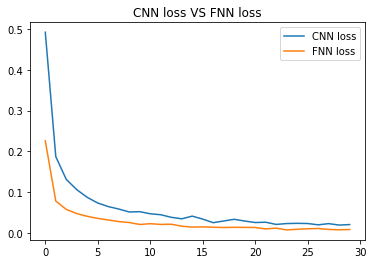

In [ ]:
# Plot loss of two models for comparasion
plt.plot(fnn_losses, label='CNN loss')
plt.plot(cnn_losses, label='FNN loss')
plt.title('CNN loss VS FNN loss')
plt.legend()

#Train all

In [ ]:
# Train All
in_trainall_tensor = torch.tensor(in_trainall)/255.0
out_trainall_tensor = torch.tensor(out_trainall)
trainall_tensor = TensorDataset(in_trainall_tensor, out_trainall_tensor)

In [ ]:
# Transform all of the training data set
trainall_data = trans(X=in_trainall, y=out_trainall, transforms=transform_train)
test_data = trans(X=in_test, transforms=transform_test)

# Load all of the training data set
load_trainall = DataLoader(trainall_data, batch_size=batch, shuffle=True)
# To test the accuracy in sequence, we don't shuffle here.
load_test = DataLoader(test_data, batch_size=batch, shuffle=False)

In [ ]:
# train the model using all of the training data
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
#error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
error = nn.CrossEntropyLoss()
# Cross Entropy is usually better than square errors

epochs = 30
for epoch in range(epochs):
  running_loss = 0

  # go through all the images in training set
  for images, labels in load_trainall:
    optimizer.zero_grad() # training pass

    outputs = cnnmodel(images)
    loss = error(outputs, labels)
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_trainall:

      outputs = cnnmodel(images)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/30 - loss: 0.0002285376491768364 - accuracy: 0.9962857365608215
Epoch 2/30 - loss: 0.000245610093773805 - accuracy: 0.9961666464805603
Epoch 3/30 - loss: 0.00021749098208907267 - accuracy: 0.996238112449646
Epoch 4/30 - loss: 0.0002024614965278358 - accuracy: 0.9963571429252625
Epoch 5/30 - loss: 0.00021861085577854413 - accuracy: 0.9957143068313599
Epoch 6/30 - loss: 0.00022574786992461104 - accuracy: 0.9963571429252625
Epoch 7/30 - loss: 0.00022470280035438573 - accuracy: 0.996238112449646
Epoch 8/30 - loss: 0.00023119915634363982 - accuracy: 0.996238112449646
Epoch 9/30 - loss: 0.0002242693268231917 - accuracy: 0.9958333373069763
Epoch 10/30 - loss: 0.00022420100022658775 - accuracy: 0.9959047436714172
Epoch 11/30 - loss: 0.0002159007800578582 - accuracy: 0.9955714344978333
Epoch 12/30 - loss: 0.00023090557308863763 - accuracy: 0.9961190223693848
Epoch 13/30 - loss: 0.00022303774814173223 - accuracy: 0.9954047799110413
Epoch 14/30 - loss: 0.00022493898359537178 - accuracy: 0

## Result

In [ ]:
# set net in test (evaluation) mode
cnnmodel.eval()  

test_predictions = []
with torch.no_grad():
    for images in load_test:
        outputs = cnnmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.numpy())
test_predictions = np.array(test_predictions)
# Add the test index in the submission format description.
test_predictions = np.stack((np.arange(1, len(test_predictions)+1), test_predictions), axis=1)
# Save to csv file with the header format that accepted by Kaggle
np.savetxt("submission.csv", test_predictions, fmt='%d', delimiter=',', header='ImageId,Label', comments='')
print(test_predictions)

[[    1     2]
 [    2     0]
 [    3     9]
 ...
 [27998     3]
 [27999     9]
 [28000     2]]
